## Import dataset

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("twitter_multi_class_sentiment.csv")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [5]:
df.isnull().sum()

text          0
label         0
label_name    0
dtype: int64

## Dataset Analysis

In [6]:
import matplotlib.pyplot as plt

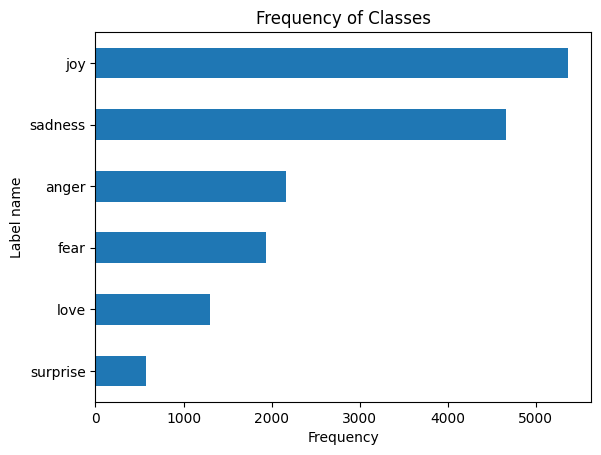

In [7]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.xlabel("Frequency")
plt.ylabel('Label name')
plt.show()

In [8]:
df['Word per Tweet'] = df['text'].str.split().apply(len)
df.head()

,text,label,label_name,Word per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


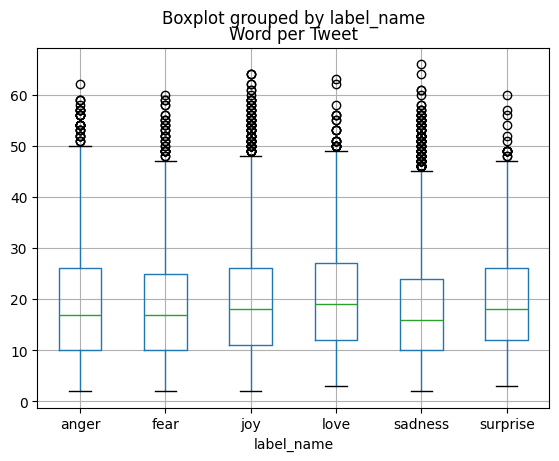

In [9]:
df.boxplot("Word per Tweet", by="label_name")
plt.show()

Love label has higher average of words than the rest of the labels. Sadness label has many outliers.

## Split dataset

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label_name'])
validation, test = train_test_split(test, test_size=2/3, random_state=42, stratify=test['label_name'])

train.shape, validation.shape, test.shape

((11200, 4), (1600, 4), (3200, 4))

In [12]:
from datasets import Dataset, DatasetDict

/home/jupyter-23522024/farrel/finetune-llm-cases/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train, preserve_index=False),
        'validation': Dataset.from_pandas(validation, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False),
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Word per Tweet'],
        num_rows: 11200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Word per Tweet'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Word per Tweet'],
        num_rows: 3200
    })
})

In [14]:
dataset['train'][0]

{'text': 'i feel unhappy it is no help for me that other persons say that i am happy how much truth there may be in it',
 'label': 0,
 'label_name': 'sadness',
 'Word per Tweet': 25}

## Tokenization

In [15]:
from transformers import AutoTokenizer

In [16]:
bert_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)

text = "I love machine learning! Tokenization is awesome!"
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

tokenize(dataset['train'][:2])

{'input_ids': [[101, 1045, 2514, 12511, 2009, 2003, 2053, 2393, 2005, 2033, 2008, 2060, 5381, 2360, 2008, 1045, 2572, 3407, 2129, 2172, 3606, 2045, 2089, 2022, 1999, 2009, 102], [101, 1045, 2001, 3110, 9191, 2043, 1045, 4149, 2009, 1998, 4415, 2043, 1045, 2001, 2725, 2026, 5789, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [18]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 3200/3200 [00:00<00:00, 12591.41 examples/s]


In [19]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Word per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Word per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Word per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
})

In [20]:
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k, v in label2id.items()}

label2id, id2label

({'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2},
 {0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'})

## Model

### Define model and config

In [21]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig

In [22]:
num_labels = len(label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = AutoConfig.from_pretrained(bert_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(bert_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define training arguments

In [23]:
from transformers import TrainingArguments

In [24]:
batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False
)

### Define compute metrics function

In [25]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [30]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    
    return {"accuracy": acc, "f1": f1}

### Train the model

In [31]:
from transformers import Trainer

In [32]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics, 
                  train_dataset=emotion_encoded['train'], 
                  eval_dataset=emotion_encoded['validation'], 
                  tokenizer=tokenizer)

/tmp/ipykernel_1787001/3543366357.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.254790,0.912500,0.911810
2,No log,0.218317,0.918125,0.919078


TrainOutput(global_step=350, training_loss=0.2970941380092076, metrics={'train_runtime': 102.5978, 'train_samples_per_second': 218.328, 'train_steps_per_second': 3.411, 'total_flos': 1001502421516800.0, 'train_loss': 0.2970941380092076, 'epoch': 2.0})

In [35]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.19469213485717773,
 'test_accuracy': 0.92375,
 'test_f1': 0.9242392039667797,
 'test_runtime': 3.986,
 'test_samples_per_second': 802.811,
 'test_steps_per_second': 12.544}

### Model evaluation

In [40]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       933
           1       0.95      0.92      0.93      1072
           2       0.78      0.87      0.82       261
           3       0.96      0.91      0.94       432
           4       0.88      0.91      0.90       387
           5       0.80      0.78      0.79       115

    accuracy                           0.92      3200
   macro avg       0.89      0.90      0.89      3200
weighted avg       0.93      0.92      0.92      3200



In [43]:
id2label

{0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'}

Label `surprise` and `love` produce low f1 score. This can happens due to the imbalance on dataset where both labels have the fewest sample. This problem could be solved by using oversampling method like SMOTE.

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

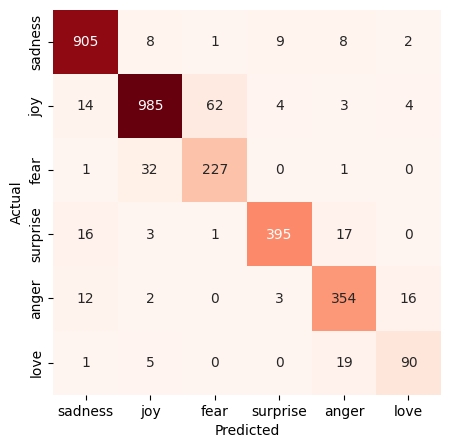

In [60]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label2id.keys(), yticklabels=label2id.keys(), cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### Save model and predict with custom data

In [67]:
text = "I got it done finally!"

def predict(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits
    pred = torch.argmax(logits).item()

    return id2label[pred]

In [70]:
predict("You are beautiful")

'joy'

In [71]:
trainer.save_model("bert-base-sentiment-model")

In [72]:
from transformers import pipeline

classifier = pipeline('text-classification', model='bert-base-sentiment-model')

classifier([text, 'You are beautiful', 'Can I get a hug?'])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9818576574325562},
 {'label': 'joy', 'score': 0.642011821269989},
 {'label': 'love', 'score': 0.4945578873157501}]